In [ ]:
!kaggle datasets download -d ahmedshahriarsakib/usa-real-estate-dataset

Dataset URL: https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset
License(s): other
 97%|████████████████████████████████████▊ | 37.0M/38.2M [00:03<00:00, 12.7MB/s]
100%|██████████████████████████████████████| 38.2M/38.2M [00:03<00:00, 12.2MB/s]


### Dataset Explanation

***USA Real Estate Dataset Updated v3 (300k+ entries) & 174 MB of data***

This dataset contains Real Estate listings in the US broken by State and zip code. (simple dataset for regression/clustering problem). Data was collected via web scraping using python libraries.

List of Attributes:

1. status: The current condition or availability of the property, such as "for sale," "sold," "pending," or "under contract"
2. price: The listed or selling price of the property (in USD)
3. bed: The number of bedrooms 
4. bath: The number of bathrooms 
5. acre_lot: The size of the lot. One acre equals 43,560 square feet.
6. full_address: The complete address of the property
7. street: The street name or number where the property is located ("Ave", "Rd", "St" ...)
8. city: The city 
9. state: The state or province 
10. zip_code: The postal code 
11. house_size: The total living area in square foot (1000 foot squared) is 93 meters squared
12. sold_date: The date when the property was sold or when the transaction was completed, indicating when the ownership officially transferred from the seller to the buyer.


Data Cleaning:

1. Extracted from the dataset only relevant columns (attributes: bed, bath, acre_lot, house_size, city, state, zip code, price)
2. Removed rows with unwanted states
3. Filtered to keep only the top 10 most frequent states
4. Removed rows with null values
5. Convert objects (non integers) to numerical format for machine to understand
6. Drop rows with missing `price` since it's the label
7. Remove rows with houses that have more than 10 beds or 10 baths, usually those arent houses but appartment complexes and skews our data

Memory Optimization:

- Convert column to more specific data type to reduce memory usage (float 64 to float 32)


Notes:

Some "houses" represent entire unit complexes (e.g., apartment buildings) one approach is to adjust the price per unit by dividing the price by the house size (square footage). This could provide a more meaningful "price per square foot" and might make more sense for comparison. Remove Rows with More Than 10 Bathrooms or 10 beds. 


In [53]:
import zipfile

with zipfile.ZipFile("usa-real-estate-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("usa_real_estate")

In [56]:
import pandas as pd

# Load dataset
data = pd.read_csv('./usa_real_estate/realtor-data.zip.csv', usecols=['bed', 'bath', 'acre_lot', 'house_size', 'city', 'state', 'zip_code', 'price'])

# Display the first five rows
print(data.head())


      price  bed  bath  acre_lot        city        state  zip_code  \
0  105000.0  3.0   2.0      0.12    Adjuntas  Puerto Rico     601.0   
1   80000.0  4.0   2.0      0.08    Adjuntas  Puerto Rico     601.0   
2   67000.0  2.0   1.0      0.15  Juana Diaz  Puerto Rico     795.0   
3  145000.0  4.0   2.0      0.10       Ponce  Puerto Rico     731.0   
4   65000.0  6.0   2.0      0.05    Mayaguez  Puerto Rico     680.0   

   house_size  
0       920.0  
1      1527.0  
2       748.0  
3      1800.0  
4         NaN  


In [ ]:
# Data Overview:
print("\nDataset Info:\n")
data.info()

# Data Cleaning:
unique_states = data['state'].unique()                          # all states available in dataset
states_to_remove = ['Puerto Rico', 'Virgin Islands', 'New Jersey', 'Tennessee', 
                    'Rhode Island',  'Wyoming',  'West Virginia', 'Delaware', 'Louisiana', 'Ohio', 
                    'Wisconsin', 'Kentucky', 'Mississippi', 'Alabama','New Brunswick', 'Texas', 
                    'Arkansas', 'Idaho', 'Indiana', 'New Mexico', 'Iowa', 'Minnesota', 'South Dakota', 
                    'Nebraska', 'North Dakota', 'Montana', 'Oklahoma', 'Oregon', 'Utah', 'Nevada',
                    'Arizona', 'Guam', 'Alaska']

data = data[~data['state'].isin(states_to_remove)]              # removing all rows with states we dont wnat

top_states = data['state'].value_counts().head(10).index        # count the frequency of each state and keep the 10 most frequent ones
data = data[data['state'].isin(top_states)]                     # filter data to keep only the top 10 most frequent states


print("\nMissing Values per Column:\n")
print(data.isnull().sum())                                                              # remove missing values 
data = pd.get_dummies(data, columns=['city', 'state'], drop_first=True, sparse=True)    # objects need to be converted to numerical format for machine to understand
data = data.dropna(subset=['price'])                                                    # drop rows with missing `price` since it's the label

data = data.query('bed <= 20 and bath <= 10') # remove rows with more than 20 beds or with more than 10 baths

data.info()


Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226382 entries, 0 to 2226381
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   price       float64
 1   bed         float64
 2   bath        float64
 3   acre_lot    float64
 4   city        object 
 5   state       object 
 6   zip_code    float64
 7   house_size  float64
dtypes: float64(6), object(2)
memory usage: 135.9+ MB

Missing Values per Column:

price            449
bed           207144
bath          214723
acre_lot      188903
city             575
state              0
zip_code          99
house_size    252108
dtype: int64


In [ ]:
# Useful features for prediction
features = ['bed', 'bath', 'acre_lot', 'house_size', 'city', 'state', 'zip_code']
label = 'price'  # we choose to forecast house prices in area

# Memory optimization
data['price'] = data['price'].astype('float32')
data['bed'] = data['bed'].astype('float32')
data['bath'] = data['bath'].astype('float32')
data['acre_lot'] = data['acre_lot'].astype('float32')
data['zip_code'] = data['zip_code'].astype('float32')
data['house_size'] = data['house_size'].astype('float32')

data.info()  # Summary of the dataset
data.describe()  # Basic statistics for numerical features


Missing Values per Column:

price            449
bed           207144
bath          214723
acre_lot      188903
city             575
state              0
zip_code          99
house_size    252108
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 1087008 entries, 5217 to 2226381
Columns: 8654 entries, price to state_Washington
dtypes: Sparse[bool, False](8648), float32(6)
memory usage: 42.5 MB


,price,bed,bath,acre_lot,zip_code,house_size
count,1.087008e+06,880028.000000,872493.000000,898250.000000,1.086910e+06,8.351910e+05
mean,6.240424e+05,3.235626,2.510939,18.647371,4.684389e+04,2.016560e+03
std,2.763466e+06,1.491609,1.610507,964.341553,3.080357e+04,1.845132e+04
min,0.000000e+00,1.000000,1.000000,0.000000,0.000000e+00,4.000000e+00
25%,1.899990e+05,3.000000,2.000000,0.140000,2.322300e+04,1.250000e+03
50%,3.700000e+05,3.000000,2.000000,0.240000,3.302300e+04,1.695000e+03
75%,6.499000e+05,4.000000,3.000000,0.750000,9.063100e+04,2.342000e+03
max,2.147484e+09,212.000000,752.000000,100000.000000,9.999900e+04,1.299220e+07


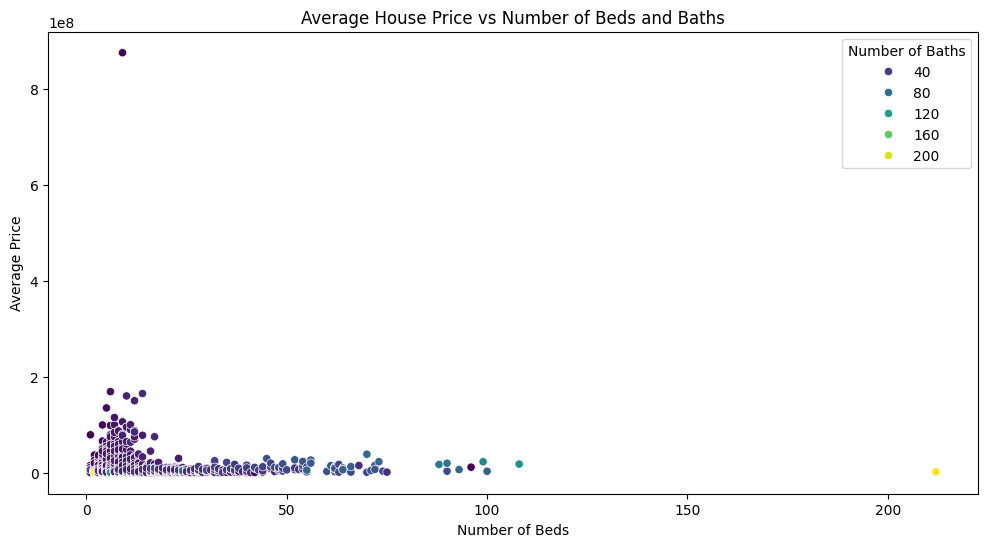

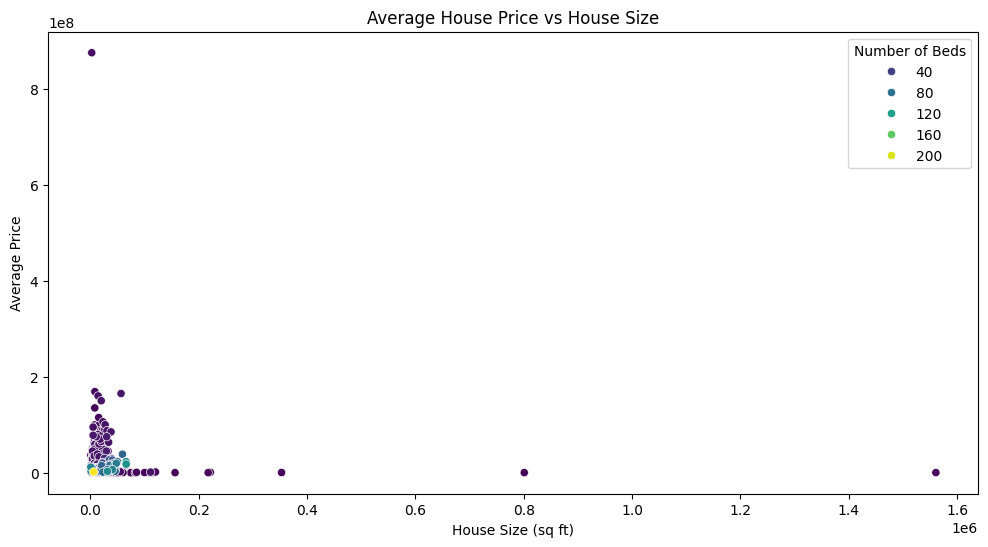

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame to summarize the average price by features
avg_price_by_features = data.groupby(['bed', 'bath', 'house_size'], as_index=False)['price'].mean()

# Set the plot size
plt.figure(figsize=(12, 6))

# Plot Average Price vs Number of Beds and Baths
sns.scatterplot(data=avg_price_by_features, x='bed', y='price', hue='bath', palette='viridis')
plt.title('Average House Price vs Number of Beds and Baths')
plt.xlabel('Number of Beds')
plt.ylabel('Average Price')
plt.legend(title='Number of Baths')
plt.show()

# Plot Average Price vs House Size
plt.figure(figsize=(12, 6))
sns.scatterplot(data=avg_price_by_features, x='house_size', y='price', hue='bed', palette='viridis')
plt.title('Average House Price vs House Size')
plt.xlabel('House Size (sq ft)')
plt.ylabel('Average Price')
plt.legend(title='Number of Beds')
plt.show()
